In [20]:
import pandas as pd

In [21]:
features = pd.read_csv('graph_features_full.csv')


In [22]:
features

,H,E,q,m,Tc,H_sub1,E_sub1,q_sub1,m_sub1,Tc_sub1,...,AvgFalffW_7_to_6,Energy_7_to_7,AvgWeight_7_to_7,AvgFalffW_7_to_7,PROP_AGREEMENT,PROP_DISAGREEMENT,PROP_IMBALANCED_SAME,PROP_IMBALANCED_OPP,bipolarity,label
0,-5.557087,-0.000279,0.000836,0.610290,14.106736,-3.986214,-0.002330,0.004860,0.607038,7.615773,...,-0.000174,-0.425481,0.011391,0.000545,0.245276,0.264925,0.252211,0.237588,0.636633,ASD
1,-11.062114,-0.000556,-0.001297,0.459667,14.106736,-1.520755,-0.000889,0.001409,0.422119,7.615773,...,0.001485,1.065063,-0.008249,-0.001365,0.253920,0.277588,0.243568,0.224925,0.620854,ASD
2,-5.702705,-0.000287,-0.000565,0.496461,14.106736,0.939722,0.000549,0.001163,0.447596,7.615773,...,-0.002011,2.315640,-0.013055,-0.002969,0.237940,0.272613,0.259548,0.229899,0.611558,ASD
3,-4.964231,-0.000249,0.000124,0.443946,14.106736,-1.667399,-0.000975,-0.001870,0.393679,7.615773,...,-0.000453,-2.178616,0.006179,0.002793,0.275477,0.275528,0.222010,0.226985,0.599296,ASD
4,3.997658,0.000201,-0.000350,0.547170,14.106736,2.790884,0.001631,-0.001763,0.517877,7.615773,...,-0.000349,2.556478,-0.006298,-0.003278,0.245779,0.275528,0.251709,0.226985,0.641256,ASD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,-16.839630,-0.000846,0.001314,0.582078,14.106736,-0.279703,-0.000163,0.000321,0.580313,7.615773,...,0.005344,-0.217752,0.002052,0.000279,0.247588,0.267085,0.249899,0.235427,0.669146,TD
182,-17.612388,-0.000885,0.001380,0.583018,14.106736,-2.170254,-0.001268,0.002364,0.583153,7.615773,...,0.006477,-0.991100,0.005199,0.001271,0.252965,0.266784,0.244523,0.235729,0.634874,TD
183,-50.609884,-0.002543,0.004261,0.582047,14.106736,-4.209308,-0.002460,0.004385,0.579150,7.615773,...,0.005415,-0.238889,0.000332,0.000306,0.247940,0.258744,0.249548,0.243769,0.649899,TD
184,-13.608638,-0.000684,0.001035,0.583023,14.106736,-2.484848,-0.001452,0.002614,0.581873,7.615773,...,0.001994,-1.365235,0.007722,0.001750,0.247136,0.269698,0.250352,0.232814,0.618894,TD


In [23]:
from scipy import stats
import numpy as np
from statsmodels.stats.multitest import multipletests

numerical_columns = features.select_dtypes(include=[np.number]).columns
results = []

for col in numerical_columns:
    asd_values = features[features['label'] == 'ASD'][col]
    td_values = features[features['label'] == 'TD'][col]
    
    # Test for normality
    asd_normal = stats.shapiro(asd_values)[1] > 0.05
    td_normal = stats.shapiro(td_values)[1] > 0.05
    
    # Test for equal variances
    levene_p = stats.levene(asd_values, td_values)[1]
    equal_var = levene_p > 0.05
    
    # Select test
    if asd_normal and td_normal:
        # Both normal
        test_name = "t-test"
        stat, p_value = stats.ttest_ind(asd_values, td_values, equal_var=equal_var)
    else:
        # Not normal, use non-parametric
        test_name = "rank-sum"
        stat, p_value = stats.ranksums(asd_values, td_values)
        results.append({
        'Feature': col,
        'ASD_Mean': round(asd_values.mean(), 3),
        'TD_Mean': round(td_values.mean(), 3),
        'Test': test_name,
        'Statistic': round(stat, 3),
        'p_value': p_value  # keep raw for correction
        })

    results_df = pd.DataFrame(results)

    # Multiple comparison correction (FDR)
    reject, pvals_corrected, _, _ = multipletests(results_df['p_value'], method='fdr_bh')
    results_df['p_value_corrected'] = pvals_corrected
    results_df['significant'] = reject

    # Only report significant ones (raw or corrected)
    sig_raw = results_df[results_df['p_value'] < 0.05]
    sig_corr = results_df[results_df['p_value_corrected'] < 0.05]

    print("Significant features (raw p < 0.05):")
    print(sig_raw[['Feature', 'ASD_Mean', 'TD_Mean', 'Test', 'Statistic', 'p_value']])

    print("\nSignificant features (FDR corrected p < 0.05):")
    print(sig_corr[['Feature', 'ASD_Mean', 'TD_Mean', 'Test', 'Statistic', 'p_value_corrected']])

Significant features (raw p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0       H   -25.599  -13.825  rank-sum     -2.268  0.023352

Significant features (FDR corrected p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic  p_value_corrected
0       H   -25.599  -13.825  rank-sum     -2.268           0.023352
Significant features (raw p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0       H   -25.599  -13.825  rank-sum     -2.268  0.023352
1       E    -0.001   -0.001  rank-sum     -2.268  0.023352

Significant features (FDR corrected p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic  p_value_corrected
0       H   -25.599  -13.825  rank-sum     -2.268           0.023352
1       E    -0.001   -0.001  rank-sum     -2.268           0.023352
Significant features (raw p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0       H   -25.599  -13.825  rank-sum     -2.268  0.023352
1       E    -0.001   -0.001

c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modelin

Significant features (raw p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0       H   -25.599  -13.825  rank-sum     -2.268  0.023352
1       E    -0.001   -0.001  rank-sum     -2.268  0.023352

Significant features (FDR corrected p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic  p_value_corrected
0       H   -25.599  -13.825  rank-sum     -2.268           0.046704
1       E    -0.001   -0.001  rank-sum     -2.268           0.046704
Significant features (raw p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0       H   -25.599  -13.825  rank-sum     -2.268  0.023352
1       E    -0.001   -0.001  rank-sum     -2.268  0.023352

Significant features (FDR corrected p < 0.05):
Empty DataFrame
Columns: [Feature, ASD_Mean, TD_Mean, Test, Statistic, p_value_corrected]
Index: []
Significant features (raw p < 0.05):
  Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0       H   -25.599  -13.825  rank-sum     -2.268  0.023352
1     

c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modelin

Significant features (raw p < 0.05):
   Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0        H   -25.599  -13.825  rank-sum     -2.268  0.023352
1        E    -0.001   -0.001  rank-sum     -2.268  0.023352
20  H_sub5    -0.539   -0.244  rank-sum     -2.142  0.032167
21  E_sub5    -0.006   -0.003  rank-sum     -2.142  0.032167
22  q_sub5     0.010    0.005  rank-sum      2.028  0.042568

Significant features (FDR corrected p < 0.05):
Empty DataFrame
Columns: [Feature, ASD_Mean, TD_Mean, Test, Statistic, p_value_corrected]
Index: []
Significant features (raw p < 0.05):
   Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0        H   -25.599  -13.825  rank-sum     -2.268  0.023352
1        E    -0.001   -0.001  rank-sum     -2.268  0.023352
20  H_sub5    -0.539   -0.244  rank-sum     -2.142  0.032167
21  E_sub5    -0.006   -0.003  rank-sum     -2.142  0.032167
22  q_sub5     0.010    0.005  rank-sum      2.028  0.042568
24  H_sub6    -4.430   -3.448  rank-sum     -2

c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Saeed\miniconda3\envs\modelin

Significant features (raw p < 0.05):
   Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0        H   -25.599  -13.825  rank-sum     -2.268  0.023352
1        E    -0.001   -0.001  rank-sum     -2.268  0.023352
20  H_sub5    -0.539   -0.244  rank-sum     -2.142  0.032167
21  E_sub5    -0.006   -0.003  rank-sum     -2.142  0.032167
22  q_sub5     0.010    0.005  rank-sum      2.028  0.042568
24  H_sub6    -4.430   -3.448  rank-sum     -2.360  0.018263
25  E_sub6    -0.016   -0.012  rank-sum     -2.360  0.018263
26  q_sub6     0.026    0.020  rank-sum      2.202  0.027648

Significant features (FDR corrected p < 0.05):
Empty DataFrame
Columns: [Feature, ASD_Mean, TD_Mean, Test, Statistic, p_value_corrected]
Index: []
Significant features (raw p < 0.05):
   Feature  ASD_Mean  TD_Mean      Test  Statistic   p_value
0        H   -25.599  -13.825  rank-sum     -2.268  0.023352
1        E    -0.001   -0.001  rank-sum     -2.268  0.023352
20  H_sub5    -0.539   -0.244  rank-sum     -2

In [24]:
# Combine significant features from both raw and FDR-corrected results
sig_features = pd.unique(
    pd.concat([sig_raw['Feature'], sig_corr['Feature']])
)

# Create a new dataframe with only the significant features and the label
signif_features_df = features[list(sig_features) + ['label']]
signif_features_df.head()

,H,E,H_sub5,E_sub5,q_sub5,H_sub6,E_sub6,q_sub6,AvgWeight_1_to_2,Energy_1_to_6,...,AvgWeight_6_to_5,AvgFalffW_6_to_5,Energy_6_to_6,AvgWeight_6_to_6,AvgFalffW_6_to_6,Energy_7_to_1,AvgFalffW_7_to_1,PROP_AGREEMENT,PROP_IMBALANCED_SAME,label
0,-5.557087,-0.000279,0.812298,0.008926,-0.015279,-4.868295,-0.017639,0.027984,0.004555,-2.314197,...,0.033126,0.013200,-4.868295,0.044277,0.017639,-9.558271,0.004050,0.245276,0.252211,ASD
1,-11.062114,-0.000556,-1.247836,-0.013712,0.021783,-2.883696,-0.010448,0.013420,-0.003284,-3.885743,...,0.051521,0.017984,-2.883696,0.024308,0.010448,-0.364826,0.000155,0.253920,0.243568,ASD
2,-5.702705,-0.000287,0.404629,0.004446,-0.008505,-4.489072,-0.016265,0.023800,-0.001538,-7.462712,...,0.010155,0.004963,-4.489072,0.042018,0.016265,1.545158,-0.000655,0.237940,0.259548,ASD
3,-4.964231,-0.000249,0.938735,0.010316,-0.020135,-1.089150,-0.003946,0.003587,0.013288,-1.758935,...,0.003471,-0.000327,-1.089150,0.011230,0.003946,-9.319795,0.003949,0.275477,0.222010,ASD
4,3.997658,0.000201,0.054910,0.000603,0.002227,-3.884362,-0.014074,0.019109,0.007233,-6.239096,...,0.043580,0.017118,-3.884362,0.032849,0.014074,2.703124,-0.001145,0.245779,0.251709,ASD


Best K: 20
Best CV accuracy: 0.662280701754386
Accuracy (top features): 0.7894736842105263
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        16
           1       0.75      0.95      0.84        22

    accuracy                           0.79        38
   macro avg       0.82      0.76      0.77        38
weighted avg       0.81      0.79      0.78        38



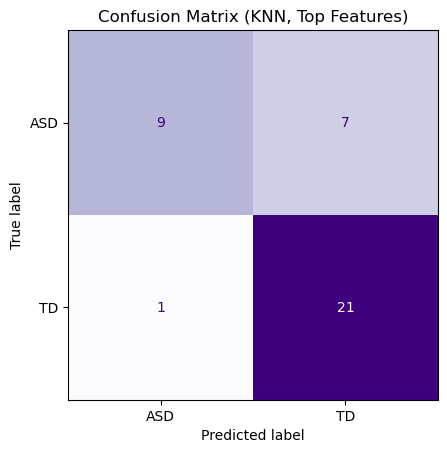

In [25]:
from sklearn.model_selection import GridSearchCV

# Use only the top features for KNN
X_top = features[top_features]
X_top = StandardScaler().fit_transform(X_top)

# Grid search for best K using cross-validation
param_grid = {'n_neighbors': list(range(2, 40)), 'metric': ['euclidean']}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_top, y)

print("Best K:", grid.best_params_['n_neighbors'])
print("Best CV accuracy:", grid.best_score_)

# Split data for final evaluation
X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Fit KNN with best K
knn_top = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'], metric='euclidean')
knn_top.fit(X_top_train, y_top_train)

# Predict and evaluate
y_top_pred = knn_top.predict(X_top_test)
print("Accuracy (top features):", accuracy_score(y_top_test, y_top_pred))
print(classification_report(y_top_test, y_top_pred))
ConfusionMatrixDisplay.from_predictions(y_top_test, y_top_pred, display_labels=['ASD', 'TD'], cmap='Purples', colorbar=False)
plt.title("Confusion Matrix (KNN, Top Features)")
plt.show()


Best K: 20
Best CV accuracy: 0.662280701754386
Accuracy (top features): 0.7894736842105263
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        16
           1       0.75      0.95      0.84        22

    accuracy                           0.79        38
   macro avg       0.82      0.76      0.77        38
weighted avg       0.81      0.79      0.78        38



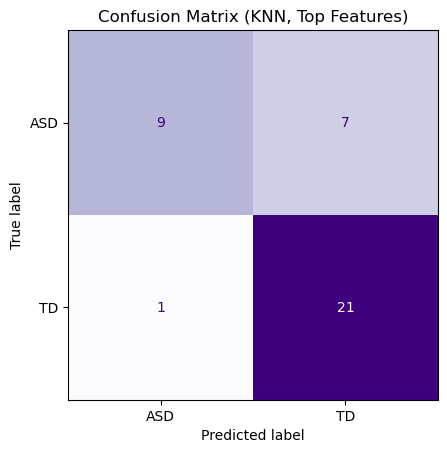

In [26]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Encode labels if needed
y = LabelEncoder().fit_transform(features['label'])

# Use only the top features for KNN
X_top = features[top_features]
X_top = StandardScaler().fit_transform(X_top)

# Grid search for best K using cross-validation
param_grid = {'n_neighbors': list(range(2, 40)), 'metric': ['euclidean']}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_top, y)

print("Best K:", grid.best_params_['n_neighbors'])
print("Best CV accuracy:", grid.best_score_)

# Split data for final evaluation
X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Fit KNN with best K
knn_top = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'], metric='euclidean')
knn_top.fit(X_top_train, y_top_train)

# Predict and evaluate
y_top_pred = knn_top.predict(X_top_test)
print("Accuracy (top features):", accuracy_score(y_top_test, y_top_pred))
print(classification_report(y_top_test, y_top_pred))
ConfusionMatrixDisplay.from_predictions(y_top_test, y_top_pred, display_labels=['ASD', 'TD'], cmap='Purples', colorbar=False)
plt.title("Confusion Matrix (KNN, Top Features)")
plt.show()

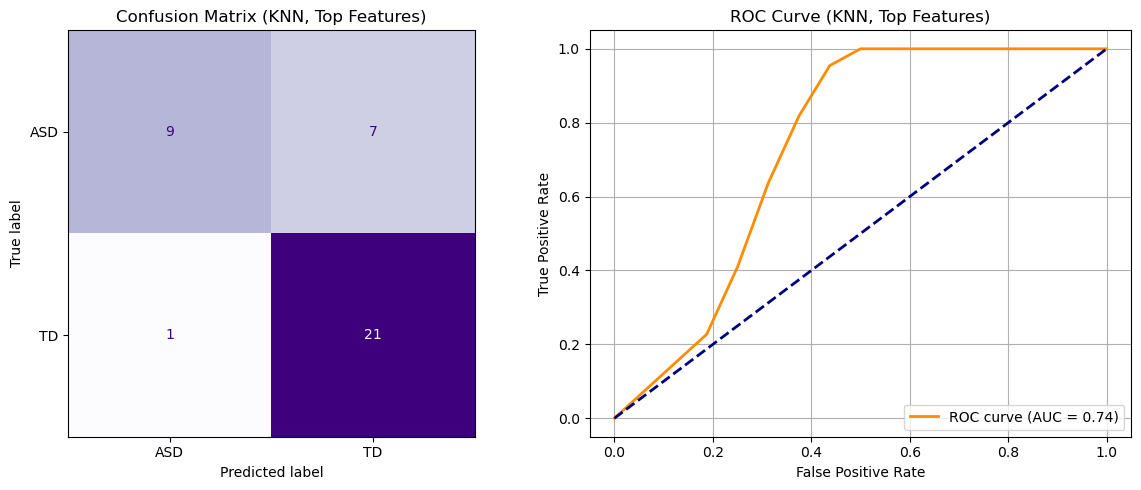

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Get predicted probabilities for the positive class
y_top_proba = knn_top.predict_proba(X_top_test)[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_top_test, y_top_pred, display_labels=['ASD', 'TD'],
    cmap='Purples', colorbar=False, ax=axs[0]
)
axs[0].set_title("Confusion Matrix (KNN, Top Features)")

# ROC Curve
fpr, tpr, _ = roc_curve(y_top_test, y_top_proba)
roc_auc = auc(fpr, tpr)
axs[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve (KNN, Top Features)')
axs[1].legend(loc="lower right")
axs[1].grid(True)

plt.tight_layout()
plt.savefig("knn_confusion_roc.png", dpi=300)
plt.show()

In [28]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Prepare train/test data (already split as X_top_train, X_top_test, y_top_train, y_top_test)

# SVM
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_top_train, y_top_train)
y_svm_pred = svm.predict(X_top_test)
svm_acc = accuracy_score(y_top_test, y_svm_pred)
print("SVM accuracy:", svm_acc)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_top_train, y_top_train)
y_xgb_pred = xgb.predict(X_top_test)
xgb_acc = accuracy_score(y_top_test, y_xgb_pred)
print("XGBoost accuracy:", xgb_acc)

# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=100000)
lr.fit(X_top_train, y_top_train)
y_lr_pred = lr.predict(X_top_test)
lr_acc = accuracy_score(y_top_test, y_lr_pred)
print("Logistic Regression accuracy:", lr_acc)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_top_train, y_top_train)
y_nb_pred = nb.predict(X_top_test)
nb_acc = accuracy_score(y_top_test, y_nb_pred)
print("Naive Bayes accuracy:", nb_acc)

SVM accuracy: 0.7894736842105263
XGBoost accuracy: 0.7105263157894737
Logistic Regression accuracy: 0.7894736842105263
Naive Bayes accuracy: 0.8157894736842105


c:\Users\Saeed\miniconda3\envs\modeling_test\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:01:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
